# 1. Importing data from HXR MD shift on 05-16-2018

This notebook takes MD data and trains a Neural Net using scikitlearn to predict the current profile at the XTCAV

In [9]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
from plotting_functions import *
path = "/Users/cemma/Documents/Work/NN_shifts_LCLS/05_16_2018_HXR_MD/Python_NN_scripts/"
sys.path.append(path)
scandata = sio.loadmat(path+'pvdata_filtered.mat',squeeze_me=True); 
#currprofile = sio.loadmat(path+'I_profiles_filtered.mat',squeeze_me=True); 
currprofile = sio.loadmat(path+'I_profiles_filtered_ROI.mat',squeeze_me=True); 
tprofile = sio.loadmat(path+'tprofile.mat',squeeze_me=True); 

pvdata = scandata['data'];
#Iz = currprofile['currprofile'];
Iz = currprofile['corrente_centro'];
tz = tprofile['tprofile'];

In [10]:
# Now choose a number of random training, validation and test shots
nsims=pvdata.shape[0]
ntrain = int(np.round(nsims*0.8));
ntest = int(np.round(nsims*0.0));
nval = int(np.round(nsims*0.2));

# Randomly index your shots for traning, validation and test sets
idx = np.random.permutation(nsims);
idxtrain = idx[0:ntrain-1];
idxval = idx[ntrain:ntrain+nval-1];
idxtest = idx[ntrain+nval:ntrain+nval+ntest];

# Split into training validation and test
traindata = pvdata[idxtrain,:];
valdata = pvdata[idxval,:];
testdata = pvdata[idxtest,:];
nsims

4046

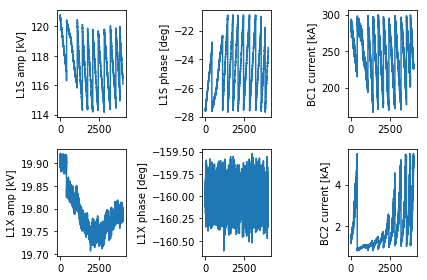

In [11]:
plot_pv_data_v2(pvdata)

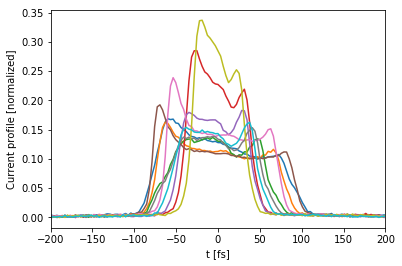

In [12]:
# For x random shots plot the current profile
for i in range(10):
    ns = int(Iz[:,0].shape+Iz[:,0].shape*(0.5*(2*np.random.rand(1,1))-1))
    plt.plot(tz[ns,:],Iz[ns,:]);
    plt.xlabel('t [fs]')
    plt.ylabel('Current profile [normalized]')
    plt.xlim([-200,200])
plt.show()

Pre-process data now i.e. split the MD scan data into predictors (the accelerator and beam diagnostics) and desired outputs (the peak current and emittance at the IP)

In [13]:
# Predictors in an array of size ntrain * 10
X = np.zeros((ntrain-1,5));
X[:,0]=traindata[:,4]; # L1s phase
X[:,1]=traindata[:,3]; # L1s amp
X[:,2]=traindata[:,7]; # BC1 pkI
X[:,3]=traindata[:,5]; # L1X amp
X[:,4]=traindata[:,20]; # BC2 pk I

In [14]:
# Predictors on validation set in an array of size ntrain * 10
X_val = np.zeros((nval-1,5));
X_val[:,0]=valdata[:,4]; # L1s phase
X_val[:,1]=valdata[:,3]; # L1s amp
X_val[:,2]=valdata[:,7]; # BC1 pk I
X_val[:,3]=valdata[:,5]; # L1X amp
X_val[:,4]=valdata[:,20]; # BC2 pkI

# 2. Now train a NN model from Sci-kit learn

In [15]:
import sklearn.neural_network as nn

In [16]:
# scale the data from 0 to 1
from sklearn import preprocessing
scale_x = preprocessing.MinMaxScaler(feature_range=(0,1))
X_scaled = scale_x.fit_transform(X);
scale_x = preprocessing.MinMaxScaler(feature_range=(0,1))
X_val_scaled = scale_x.fit_transform(X_val);

In [17]:
Iztrain = Iz[idxtrain,:]
tztrain = tz[idxtrain,:]

Izval = Iz[idxval,:]
tzval = tz[idxval,:]

Iz_scaled = Iztrain;
Iz_val_scaled = Izval;

In [18]:
# This works with a 0.63 score for both training and test sets
# nn_model = nn.MLPRegressor(
#     activation = 'tanh',
#     alpha = 1.0e-5, #L2 penalty parameter (default 1e-4)
#     batch_size = 'auto',
# #    hidden_layer_sizes = (100,20), # 60% accurate on test set
#     hidden_layer_sizes = (20,10),# 62% accurate on test set
# #    hidden_layer_sizes = (200,100,50,10),# 62% accurate on test set - weirdly looks better than the above
#     learning_rate = 'adaptive',
#     learning_rate_init = 0.001,# Only for sgd or adam
#     max_iter = 1000,
#     solver = 'lbfgs',
#     beta_1 = 0.3,beta_2=0.59,# Only used for Adam solver
#     shuffle = True,
#     early_stopping = True,
#     validation_fraction = 0.1,
#     verbose = True,
#     warm_start = False,
#     random_state = None
# )

In [19]:
nn_model = nn.MLPRegressor(
    activation = 'tanh',
    alpha = 1.0e-5, #L2 penalty parameter (default 1e-4)
    batch_size = 'auto',
#    hidden_layer_sizes = (100,20), # 60% accurate on test set
    hidden_layer_sizes = (20,10),# 62% accurate on test set
#    hidden_layer_sizes = (200,100,50,10),# 62% accurate on test set - weirdly looks better than the above
    learning_rate = 'adaptive',
    learning_rate_init = 0.001,# Only for sgd or adam
    max_iter = 1000,
    solver = 'lbfgs',
    beta_1 = 0.3,beta_2=0.59,# Only used for Adam solver
    shuffle = True,
    early_stopping = True,
    validation_fraction = 0.1,
    verbose = True,
    warm_start = False,
    random_state = None
)

In [20]:
# Fit the nn model on the training set
nn_model.fit(X_scaled,Iz_scaled)
# Predict on training and validation set
predict_Iz = nn_model.predict(X_scaled)

In [21]:
# Fit the nn model on the validation set
predict_Iz_val = nn_model.predict(X_val_scaled)

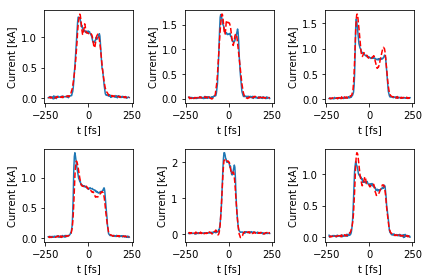

In [22]:
plot_pred_vs_actual_v2(tztrain,Iz_scaled,predict_Iz)

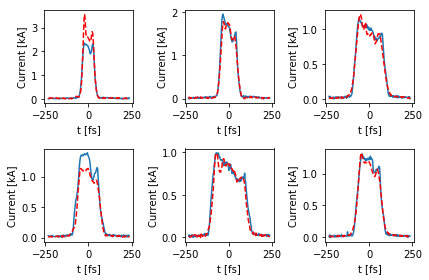

In [23]:
plot_pred_vs_actual_v2(tzval,Iz_val_scaled,predict_Iz_val)

In [24]:
print("Score on training set = ",str(nn_model.score(X_scaled,Iz_scaled)))
print("Score on test set = ",str(nn_model.score(X_val_scaled,Iz_val_scaled)))

Score on training set =  0.833785115268
Score on test set =  0.834698852705


In [25]:
if nn_model.solver == 'adam':
    import pandas as pd
    pd.DataFrame(nn_model.loss_curve_).plot()
    plt.show()

# 3. Now train a model for 2d LPS prediction

In [26]:
lpsdata = sio.loadmat(path+'tcav_img_ROI.mat',squeeze_me=True);
lpsdata = lpsdata['tcav_img_ROI'];

In [27]:
# Outputs in an array of size ntrain * 2
lpstrain = np.zeros((lpsdata.shape[1],lpsdata.shape[2],ntrain-1));
lpstrain=lpsdata[:,:,idxtrain]; #LPS data for training
lpstest = np.zeros((lpsdata.shape[1],lpsdata.shape[2],nval));
lpstest=lpsdata[:,:,idxval]; # Test data outputs in an array of size ntrain * 2

In [28]:
dt = 3.1531; # Time resolution From Alberto's TCAV axis conversion [fs/pixel]
dE = -0.88842;# Energy resolution [MeV/pix]
x = (np.arange(lpstrain.shape[0])-np.round(lpstrain.shape[0]/2))*dt;
y = (np.arange(lpstrain.shape[1])-np.round(lpstrain.shape[1]/2))*dE;
X, Y = np.meshgrid(x,y);

In [29]:
for i in range(0):    
    plot_lps_and_current(lpstrain,x,y,tztrain,Iztrain)    

In [30]:
# Reshape the 3d array into a 2d array so you can use it in the scikitlearn neural net
lpstrainreshaped = np.zeros((lpstrain.shape[2],lpsdata.shape[0]*lpsdata.shape[1]))
lpstestreshaped = np.zeros((lpstest.shape[2],lpsdata.shape[0]*lpsdata.shape[1]))
for i in range(lpstrain.shape[2]):
    lpstrainreshaped[i,:] = lpstrain[:,:,i].reshape(lpsdata.shape[0]*lpsdata.shape[1])
    
for i in range(lpstest.shape[2]):
    lpstestreshaped[i,:] = lpstest[:,:,i].reshape(lpsdata.shape[0]*lpsdata.shape[1])

In [31]:
# This gets a score of 0.75 and pretty decent reconstructions

# # Initialize the neural network model
# lps_nn_model = nn.MLPRegressor(
#     activation = 'tanh',
#     alpha = 5.0e-5,
#     batch_size = 50,
#     tol = 1e-4,# default 1e-4
#     hidden_layer_sizes = (100,50),
#     solver = 'adam',
#     learning_rate = 'adaptive',# Only for sgd solver
#     learning_rate_init = 5.0e-5,
#     max_iter = 5000,
#     beta_1 = 0.9,beta_2=0.999,# Only for adam solver
#     shuffle = True,
#     early_stopping = True,
#     validation_fraction = 0.1,
#     verbose = True,
#     momentum = 0.7,# Only used for sgd solver
#     warm_start = False,
#     random_state = None
# )

In [32]:
# Initialize the neural network model
lps_nn_model = nn.MLPRegressor(
    activation = 'tanh',
    alpha = 5.0e-5,
    batch_size = 50,
    tol = 1e-4,# default 1e-4
    hidden_layer_sizes = (100,50),
    solver = 'adam',
    learning_rate = 'adaptive',# Only for sgd solver
    learning_rate_init = 5.0e-5,
    max_iter = 5000,
    beta_1 = 0.9,beta_2=0.999,# Only for adam solver
    shuffle = True,
    early_stopping = True,
    validation_fraction = 0.1,
    verbose = True,
    momentum = 0.7,# Only used for sgd solver
    warm_start = False,
    random_state = None
)

In [33]:
# Fit the nn model on the training set
lps_nn_model.fit(X_scaled,lpstrainreshaped)
# Predict on training and validation set
predict_lps = lps_nn_model.predict(X_scaled)

Iteration 1, loss = 0.00368303
Validation score: -0.618789
Iteration 2, loss = 0.00297525
Validation score: -0.313712
Iteration 3, loss = 0.00246663
Validation score: -0.121103
Iteration 4, loss = 0.00219169
Validation score: -0.032002
Iteration 5, loss = 0.00206928
Validation score: 0.009289
Iteration 6, loss = 0.00200948
Validation score: 0.031974
Iteration 7, loss = 0.00197049
Validation score: 0.049776
Iteration 8, loss = 0.00193677
Validation score: 0.065971
Iteration 9, loss = 0.00190249
Validation score: 0.084376
Iteration 10, loss = 0.00186551
Validation score: 0.104046
Iteration 11, loss = 0.00182816
Validation score: 0.122623
Iteration 12, loss = 0.00178950
Validation score: 0.142095
Iteration 13, loss = 0.00175070
Validation score: 0.161000
Iteration 14, loss = 0.00171213
Validation score: 0.180212
Iteration 15, loss = 0.00167459
Validation score: 0.198187
Iteration 16, loss = 0.00163789
Validation score: 0.215760
Iteration 17, loss = 0.00160303
Validation score: 0.232705
It

Iteration 140, loss = 0.00097210
Validation score: 0.574368
Iteration 141, loss = 0.00097011
Validation score: 0.574534
Iteration 142, loss = 0.00096846
Validation score: 0.576268
Iteration 143, loss = 0.00096641
Validation score: 0.577295
Iteration 144, loss = 0.00096448
Validation score: 0.579546
Iteration 145, loss = 0.00096268
Validation score: 0.580608
Iteration 146, loss = 0.00096073
Validation score: 0.580562
Iteration 147, loss = 0.00095868
Validation score: 0.582653
Iteration 148, loss = 0.00095633
Validation score: 0.584076
Iteration 149, loss = 0.00095499
Validation score: 0.584793
Iteration 150, loss = 0.00095297
Validation score: 0.585823
Iteration 151, loss = 0.00095137
Validation score: 0.587605
Iteration 152, loss = 0.00094936
Validation score: 0.589486
Iteration 153, loss = 0.00094770
Validation score: 0.589876
Iteration 154, loss = 0.00094556
Validation score: 0.590139
Iteration 155, loss = 0.00094386
Validation score: 0.593015
Iteration 156, loss = 0.00094222
Validat

Iteration 277, loss = 0.00080682
Validation score: 0.693129
Iteration 278, loss = 0.00080612
Validation score: 0.694380
Iteration 279, loss = 0.00080542
Validation score: 0.694392
Iteration 280, loss = 0.00080455
Validation score: 0.695689
Iteration 281, loss = 0.00080455
Validation score: 0.695129
Iteration 282, loss = 0.00080364
Validation score: 0.696429
Iteration 283, loss = 0.00080296
Validation score: 0.696638
Iteration 284, loss = 0.00080227
Validation score: 0.698143
Iteration 285, loss = 0.00080155
Validation score: 0.697832
Iteration 286, loss = 0.00080105
Validation score: 0.699569
Iteration 287, loss = 0.00080068
Validation score: 0.698694
Iteration 288, loss = 0.00079974
Validation score: 0.699801
Iteration 289, loss = 0.00079917
Validation score: 0.700594
Iteration 290, loss = 0.00079859
Validation score: 0.700481
Iteration 291, loss = 0.00079803
Validation score: 0.701609
Iteration 292, loss = 0.00079716
Validation score: 0.701256
Iteration 293, loss = 0.00079696
Validat

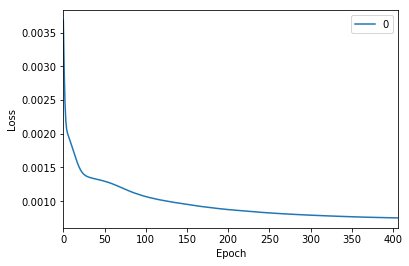

In [34]:
if lps_nn_model.solver == 'adam':
    import pandas as pd
    pd.DataFrame(lps_nn_model.loss_curve_).plot()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [35]:
# Re-shape the predicted LPS into a 2d array to compare with the actual LPS
predict_lpsreshaped = np.zeros((lpstrain.shape[0],lpstrain.shape[1],lpstrain.shape[2]))
for i in range(predict_lps.shape[0]):
    predict_lpsreshaped[:,:,i] = predict_lps[i,:].reshape(lpsdata.shape[0],lpsdata.shape[1])

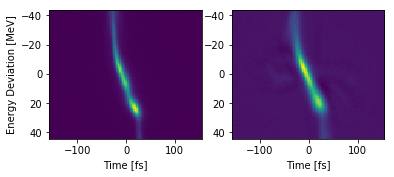

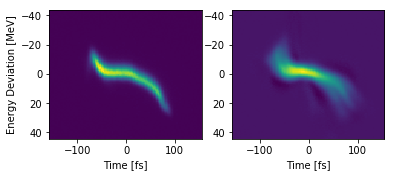

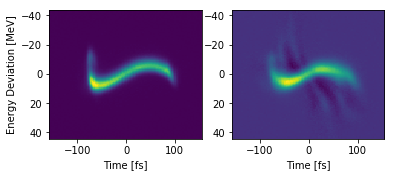

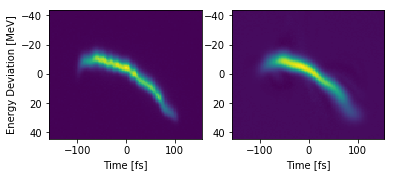

In [36]:
for i in range(4):
    plot_lps_vs_prediction_v2(lpstrain,predict_lpsreshaped,x,y)    

In [37]:
print("Score on training set = ",str(lps_nn_model.score(X_scaled,lpstrainreshaped)))

Score on training set =  0.746068790995


Predict on the test set

In [38]:
predict_lps_testset = lps_nn_model.predict(X_val_scaled)
predicted_lps_testset_2d = np.zeros((lpstest.shape[0],lpstest.shape[1],lpstest.shape[2]))
for i in range(predict_lps_testset.shape[0]):
    predicted_lps_testset_2d[:,:,i] = predict_lps_testset[i,:].reshape(lpsdata.shape[0],lpsdata.shape[1])

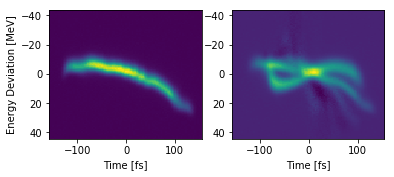

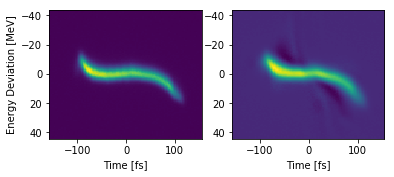

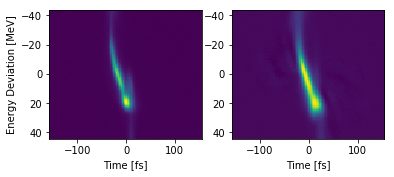

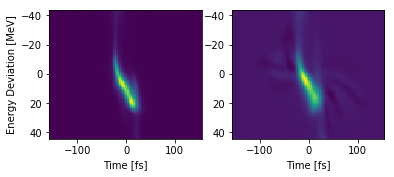

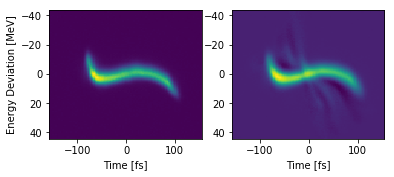

In [39]:
for i in range(5):
    plot_lps_vs_prediction_v2(lpstest,predicted_lps_testset_2d,x,y)   

In [40]:
print("Score on test set = ",str(lps_nn_model.score(X_val_scaled,lpstestreshaped)))

Score on test set =  0.745672209892


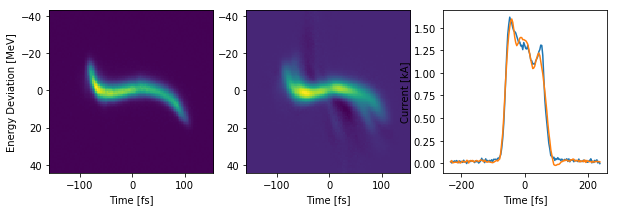

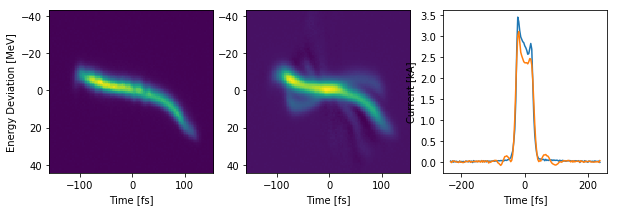

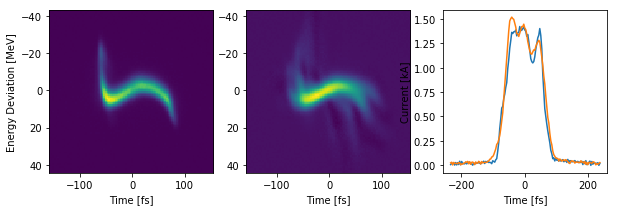

In [41]:
from plotting_functions import *
for i in range(3):
    plot_lps_and_current_w_prediction(lpstest,predicted_lps_testset_2d,x,y,tztrain,Iz_scaled,predict_Iz)

# Now plot the 2d LPS prediction and current profile prediction

163


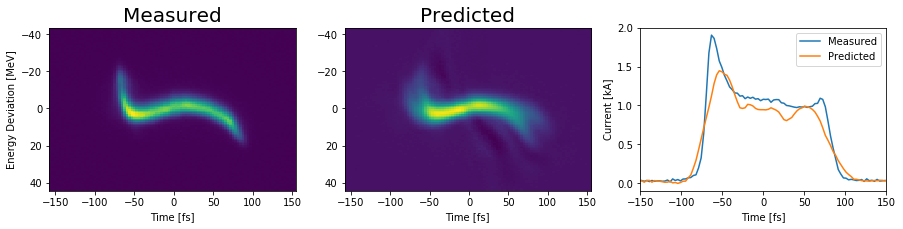

165


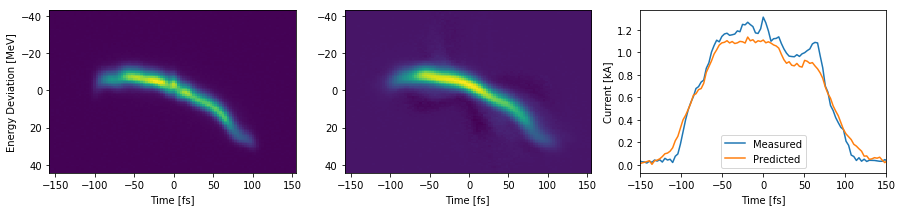

414


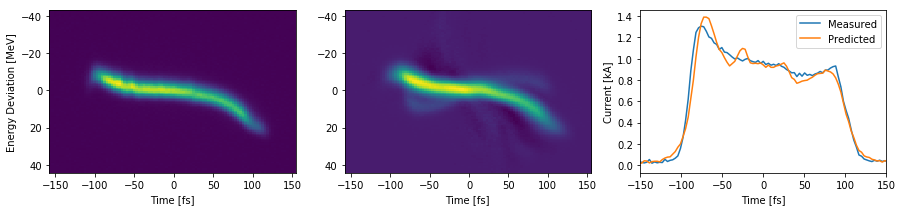

In [42]:
for n in range(3):
    ns = int(lpstest.shape[2]+lpstest.shape[2]*(0.5*(2*np.random.rand(1,1))-1));
    print(ns)
    curr_integral = np.trapz(Iz_scaled[ns,:],x=tztrain[ns,:]*1e-15);
    conv_factor = 180e-12/curr_integral*1e-3;
    fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))
    ax.imshow(lpstest[:,:,ns],extent=(x[0],x[x.shape[0]-1],y[0],y[y.shape[0]-1]),aspect = "auto")
    if n==0:
        ax.set_title('Measured',fontsize = 20)
    
    ax.set_xlabel('Time [fs]')
    ax.set_ylabel('Energy Deviation [MeV]')
    ax3.plot(tztrain[ns,:],Iz_val_scaled[ns,:]*conv_factor,label='Measured')
    ax3.plot(tztrain[ns,:],predict_Iz_val[ns,:]*conv_factor,label='Predicted')
    ax3.set_xlabel('Time [fs]')
    ax3.set_ylabel('Current [kA]')
    ax3.set_xlim([-150,150])
    ax3.legend()
    ax2.set_aspect("auto")
    if n==0:
        ax2.set_title('Predicted',fontsize = 20)
    ax2.imshow(predicted_lps_testset_2d[:,:,ns],extent=(x[0],x[x.shape[0]-1],y[0],y[y.shape[0]-1]),aspect = "auto")
    ax2.set_xlabel('Time [fs]')
    ax2.set_aspect("auto")
    plt.show()

# Now predict the 2d LPS using the predicted current profile or peak current as input to the NN

# Save the predicted LPS and current profile and ground truth to matlab variables for further post-processing

In [43]:
# # Save stuff to matlab variables so I can put them into my Matlab figure of merit function
pvdata_testset = testdata;
sio.savemat('Iz_test.mat',mdict={'Iz_test_scaled': Iz_val_scaled})
sio.savemat('tztest.mat',mdict={'tztest': tzval})
sio.savemat('predict_Iz_test.mat',mdict={'predict_Iz_test': predict_Iz_val})
sio.savemat('pvdata_testset.mat',mdict={'pvdata_testset': pvdata_testset})

In [44]:
# # Save stuff to matlab variables so I can put them into my Matlab figure of merit function
sio.savemat('lpstest.mat',mdict={'lpstest': lpstest})
sio.savemat('predicted_lps_testset_2d.mat',mdict={'predicted_lps_testset_2d': predicted_lps_testset_2d})
sio.savemat('valdata.mat',mdict={'valdata': valdata});